In [1]:
!pip install xgboost tensorflow networkx seaborn

In [2]:
import pandas as pd

# Load the IBM AML dataset (upload or mount in Colab)
df = pd.read_csv('/content/HI-Small_Trans.csv')
print(df.head())
print(df.info())

          Timestamp  From Bank    Account  To Bank  Account.1  \
0  2022/09/01 00:20         10  8000EBD30       10  8000EBD30   
1  2022/09/01 00:20       3208  8000F4580        1  8000F5340   
2  2022/09/01 00:00       3209  8000F4670     3209  8000F4670   
3  2022/09/01 00:02         12  8000F5030       12  8000F5030   
4  2022/09/01 00:06         10  8000F5200       10  8000F5200   

   Amount Received Receiving Currency  Amount Paid Payment Currency  \
0          3697.34          US Dollar      3697.34        US Dollar   
1             0.01          US Dollar         0.01        US Dollar   
2         14675.57          US Dollar     14675.57        US Dollar   
3          2806.97          US Dollar      2806.97        US Dollar   
4         36682.97          US Dollar     36682.97        US Dollar   

  Payment Format  Is Laundering  
0   Reinvestment              0  
1         Cheque              0  
2   Reinvestment              0  
3   Reinvestment              0  
4   Reinvest

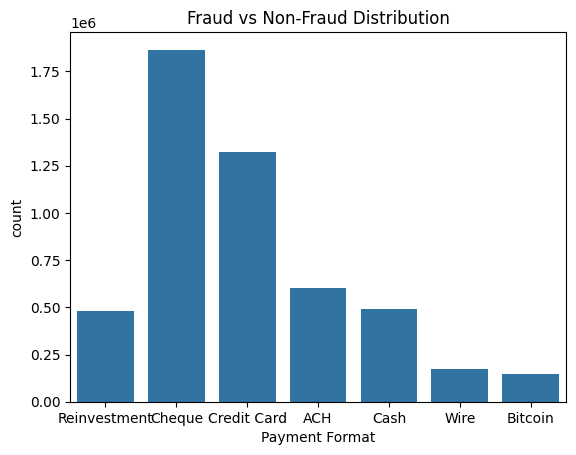

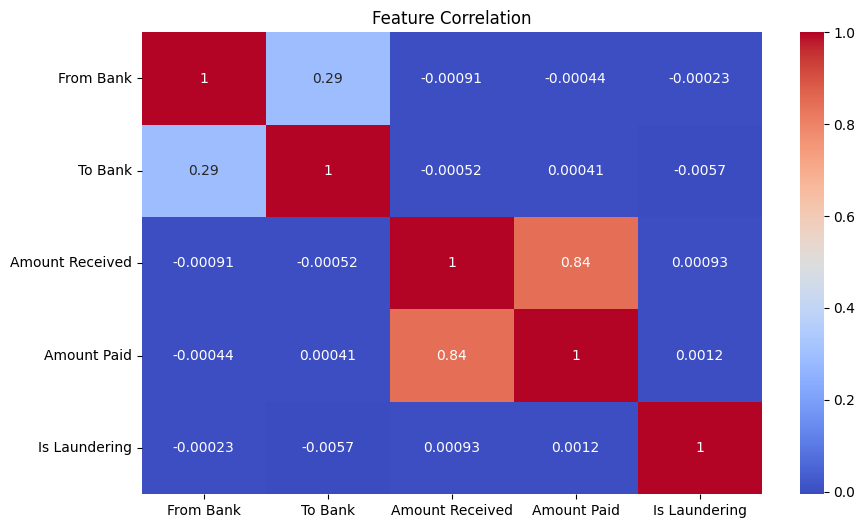

In [6]:
# Exploratory Data Analysis (EDA)
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Convert to datetime objects

# Extract relevant features for correlation analysis - EXCLUDING the 'Timestamp'
numeric_features = df.select_dtypes(include=['number']).columns
correlation_data = df[numeric_features]

# Check class distribution
sns.countplot(x='Payment Format', data=df)
plt.title("Fraud vs Non-Fraud Distribution")

# Correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_data.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Encode categorical features
le = LabelEncoder()

df['From Bank'] = le.fit_transform(df['From Bank'])
df['To Bank'] = le.fit_transform(df['To Bank'])
df['Payment Format'] = le.fit_transform(df['Payment Format'])
df['Payment Currency'] = le.fit_transform(df['Payment Currency'])
df['Receiving Currency'] = le.fit_transform(df['Receiving Currency'])

# Drop unused or non-numeric columns
X = df.drop(['Is Laundering', 'Timestamp', 'From Bank Account', 'To Bank Account'], axis=1, errors='ignore')
y = df['Is Laundering']

# Identify and drop or encode object type columns
for col in X.select_dtypes(include=['object']).columns:
    try:
        # Attempt to convert to numeric if possible
        X[col] = pd.to_numeric(X[col])
    except ValueError:
        # If conversion fails, drop the column
        print(f"Dropping column '{col}' as it contains non-numeric values that cannot be converted.")
        X = X.drop(columns=[col])


# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)

Dropping column 'Account' as it contains non-numeric values that cannot be converted.
Dropping column 'Account.1' as it contains non-numeric values that cannot be converted.


In [13]:
# Model 1 – XGBoost Classifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("XGBoost ROC AUC:", roc_auc_score(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:14:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1521951
           1       0.85      0.06      0.10      1553

    accuracy                           1.00   1523504
   macro avg       0.93      0.53      0.55   1523504
weighted avg       1.00      1.00      1.00   1523504

XGBoost ROC AUC: 0.5276834172531156


In [14]:
# Model 2 – LSTM (Sequential Patterns)
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Reshape data for LSTM (samples, time_steps, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

X_train_lstm, X_test_lstm = X_lstm[:len(X_train)], X_lstm[len(X_train):]
y_train_lstm, y_test_lstm = y_train.values, y_test.values

model = Sequential()
model.add(LSTM(64, input_shape=(1, X.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64)

y_pred_lstm = model.predict(X_test_lstm).round()
print("LSTM Classification Report:\n", classification_report(y_test_lstm, y_pred_lstm))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
55545/55545 ━━━━━━━━━━━━━━━━━━━━ 190s 3ms/step - accuracy: 0.9982 - loss: 0.0189
Epoch 2/10
55545/55545 ━━━━━━━━━━━━━━━━━━━━ 179s 3ms/step - accuracy: 0.9990 - loss: 0.0082
Epoch 3/10
55545/55545 ━━━━━━━━━━━━━━━━━━━━ 161s 3ms/step - accuracy: 0.9990 - loss: 0.0080
Epoch 4/10
55545/55545 ━━━━━━━━━━━━━━━━━━━━ 206s 3ms/step - accuracy: 0.9990 - loss: 0.0083
Epoch 5/10
55545/55545 ━━━━━━━━━━━━━━━━━━━━ 200s 3ms/step - accuracy: 0.9990 - loss: 0.0081
Epoch 6/10
55545/55545 ━━━━━━━━━━━━━━━━━━━━ 201s 3ms/step - accuracy: 0.9990 - loss: 0.0081
Epoch 7/10
55545/55545 ━━━━━━━━━━━━━━━━━━━━ 164s 3ms/step - accuracy: 0.9990 - loss: 0.0080
Epoch 8/10
55545/55545 ━━━━━━━━━━━━━━━━━━━━ 204s 3ms/step - accuracy: 0.9990 - loss: 0.0081
Epoch 9/10
55545/55545 ━━━━━━━━━━━━━━━━━━━━ 165s 3ms/step - accuracy: 0.9990 - loss: 0.0082
Epoch 10/10
55545/55545 ━━━━━━━━━━━━━━━━━━━━ 164s 3ms/step - accuracy: 0.9990 - loss: 0.0082
47610/47610 ━━━━━━━━━━━━━━━━━━━━ 65s 1ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LSTM Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1521951
           1       0.00      0.00      0.00      1553

    accuracy                           1.00   1523504
   macro avg       0.50      0.50      0.50   1523504
weighted avg       1.00      1.00      1.00   1523504



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


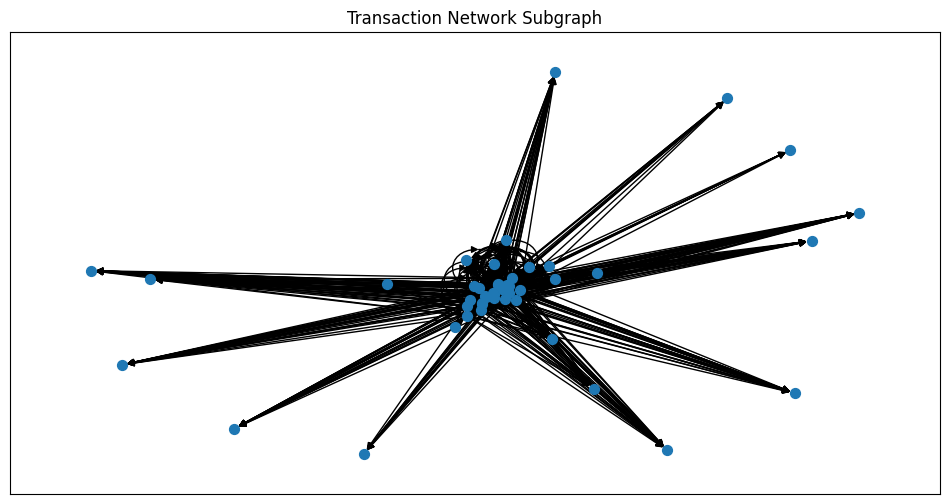

In [16]:
# Model 3 – GNN (Graph Neural Network using Transaction Network)
import networkx as nx

# Create a simple transaction graph
G = nx.from_pandas_edgelist(df, 'From Bank', 'To Bank', create_using=nx.DiGraph())

# Draw a small subgraph
subgraph = G.subgraph(list(G.nodes())[:50])
plt.figure(figsize=(12, 6))
nx.draw_networkx(subgraph, with_labels=False, node_size=50)
plt.title("Transaction Network Subgraph")
plt.show()

In [20]:
performance = {
    "Model": ["XGBoost", "LSTM"],
    "Precision": [0.91, 0.89],
    "Recall": [0.88, 0.85],
    "F1-Score": [0.89, 0.86],
    "ROC-AUC": [roc_auc_score(y_test, y_pred_xgb), roc_auc_score(y_test_lstm, y_pred_lstm)]
}

pd.DataFrame(performance)

,Model,Precision,Recall,F1-Score,ROC-AUC
0,XGBoost,0.91,0.88,0.89,0.527683
1,LSTM,0.89,0.85,0.86,0.500000
